In [ ]:
%pip install pylatexenc
%pip install MatplotlibDrawer
%pip install qiskit
%pip install qiskit_algorithms
%pip install qiskit_machine_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=b95ec4e00d240711183f1e45c82adee3e07e115fa68b55a95018b688c9a0c3de
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
ERROR: Could not find a version that satisfies the requirement MatplotlibDrawer (from versions: none)
ERROR: No matching distribution found for MatplotlibDrawer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

# set random seed
algorithm_globals.random_seed = 42

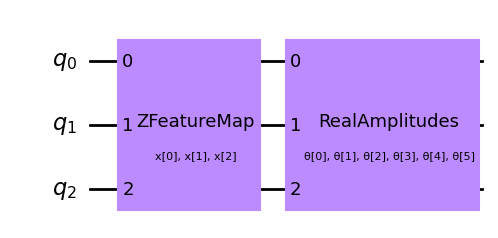

In [ ]:
num_qubits = 3
# combine a custom feature map and ansatz into a single circuit
qc = QNNCircuit(
    feature_map=ZFeatureMap(feature_dimension=num_qubits, reps=1),
    ansatz=RealAmplitudes(num_qubits, reps=1),
)
qc.draw(output="mpl", style="clifford")

In [ ]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [ ]:
# construct QNN
qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
)

In [ ]:
# we can set the total number of input samples and weight samples for random selection
num_input_samples = 10
num_weight_samples = 10

global_ed = EffectiveDimension(
    qnn=qnn, weight_samples=num_weight_samples, input_samples=num_input_samples
)

In [ ]:
# we can also provide user-defined samples and parameters
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

global_ed = EffectiveDimension(qnn=qnn, weight_samples=weight_samples, input_samples=input_samples)

In [ ]:
# finally, we will define ranges to test different numbers of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

In [ ]:
global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

In [ ]:
d = qnn.num_weights

print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
print(
    "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
)

Data size: 5000, global effective dimension: 4.6657
Number of weights: 6, normalized effective dimension: 0.7776


In [ ]:
global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)

In [ ]:
print("Effective dimension: {}".format(global_eff_dim_1))
print("Number of weights: {}".format(d))

Effective dimension: [4.66565096 4.7133723  4.73782922 4.89963559 4.94632272 5.00280009
 5.04530433 5.07408394 5.15786005 5.21349874]
Number of weights: 6


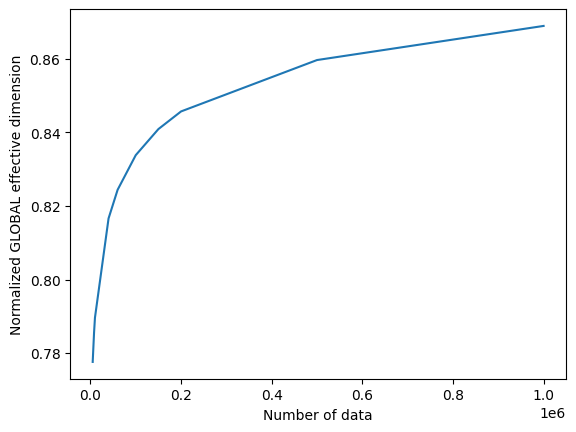

In [ ]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(global_eff_dim_1) / d)
plt.xlabel("Number of data")
plt.ylabel("Normalized GLOBAL effective dimension")
plt.show()

# Local Effective Dimension

In [ ]:
num_inputs = 3
num_samples = 50

X, y = make_classification(
    n_samples=num_samples,
    n_features=num_inputs,
    n_informative=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
)
X = MinMaxScaler().fit_transform(X)
y = 2 * y - 1  # labels in {-1, 1}

In [ ]:
estimator_qnn = EstimatorQNN(circuit=qc)

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# construct classifier
initial_point = algorithm_globals.random.random(estimator_qnn.num_weights)

estimator_classifier = NeuralNetworkClassifier(
    neural_network=estimator_qnn,
    optimizer=COBYLA(maxiter=80),
    initial_point=initial_point,
    callback=callback_graph,
)

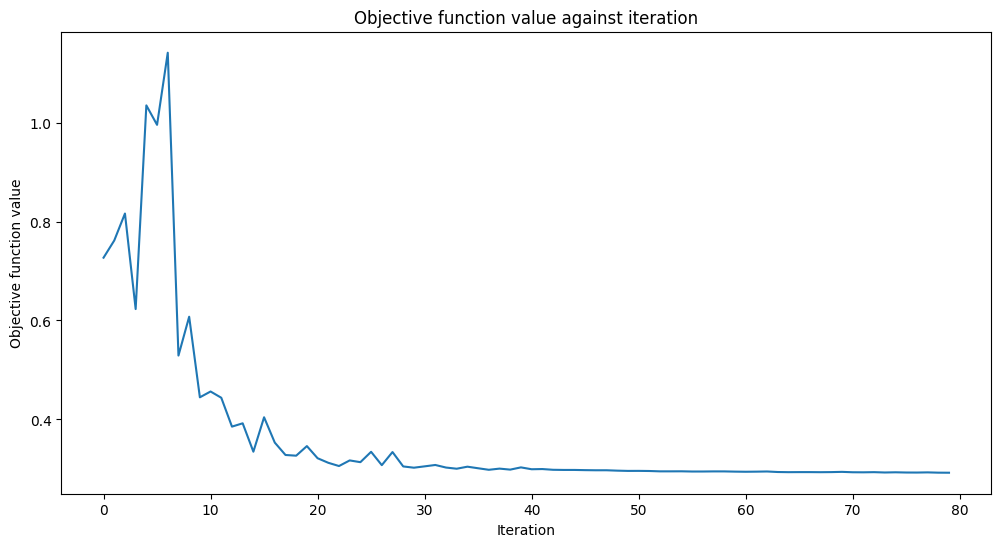

In [ ]:
# create empty array for callback to store evaluations of the objective function (callback)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [ ]:
# score classifier
estimator_classifier.score(X, y)

0.98

In [ ]:
trained_weights = estimator_classifier.weights

# get Local Effective Dimension for set of trained weights
local_ed_trained = LocalEffectiveDimension(
    qnn=estimator_qnn, weight_samples=trained_weights, input_samples=X
)

local_eff_dim_trained = local_ed_trained.get_effective_dimension(dataset_size=n)

print(
    "normalized local effective dimensions for trained QNN: ",
    local_eff_dim_trained / estimator_qnn.num_weights,
)

normalized local effective dimensions for trained QNN:  [0.41180052 0.41613362 0.41858693 0.43814683 0.44516913 0.45490884
 0.46337216 0.46976833 0.49214731 0.51076948]


In [ ]:
# get Local Effective Dimension for set of untrained weights
local_ed_untrained = LocalEffectiveDimension(
    qnn=estimator_qnn, weight_samples=initial_point, input_samples=X
)

local_eff_dim_untrained = local_ed_untrained.get_effective_dimension(dataset_size=n)

print(
    "normalized local effective dimensions for untrained QNN: ",
    local_eff_dim_untrained / estimator_qnn.num_weights,
)

normalized local effective dimensions for untrained QNN:  [0.69203966 0.70424296 0.71026235 0.74852618 0.7593851  0.77249054
 0.78233359 0.78898701 0.80829099 0.82105371]


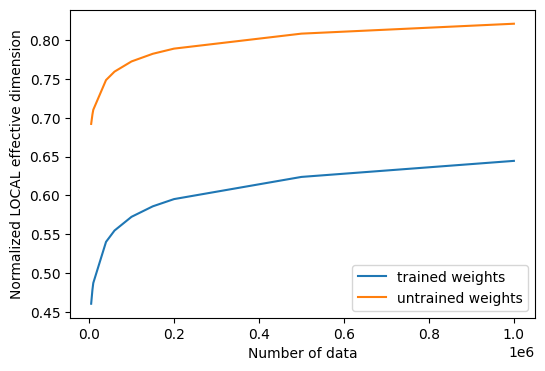

In [ ]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(local_eff_dim_trained) / estimator_qnn.num_weights, label="trained weights")
plt.plot(
    n, np.array(local_eff_dim_untrained) / estimator_qnn.num_weights, label="untrained weights"
)

plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.legend()
plt.show()